# Behavioral Cloning for Self-Driving Cars

The goal of this notebook is to explain the pipeline and training of a CNN capable of learning the appropiate way a car needs to drive. 


The CNN is trained using supervised learning: 
* The inputs to the CNN are images taken from the front-center, front-left and front-right images of a car. 
* The labels are the steering angles of the drive wheel.

The data for the CNN was obtained using [Udacity's simulator for MacOS X](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/58ae4594_mac-sim.app/mac-sim.app.zip), which records input images and their corresponding steering angles of any chosen run one wants to record their data while driving the car. It is an open source simulator and free of use.

Sample data used in this notebook for training the CNN can be downloaded [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip).

In order to run this notebook, one needs to download/get data from Udacity's simulator and save it in a folder name _data_ on the same directory of this notebook.

## Data Analysis

First we load the sample data index csv file that only contains the name of the files, steering angle, speed, throttle, break, etc.

In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

DATA_PATH = './data/'
DATA_CSV = DATA_PATH + 'driving_log.csv'

drive_data = pd.read_csv(DATA_CSV)

print('Columns in the {} file:'.format(DATA_CSV))
columns = drive_data.keys()
for c in columns:
    print('\t- {}'.format(c))


Columns in the ./data/driving_log.csv file:
	- center
	- left
	- right
	- steering
	- throttle
	- brake
	- speed


### Columns Description

* The _center_, _left_ and _right_ columns are strings that have the path where the image of the corresponding camera for that row is stored.

* _Steering_ is the value of the driving wheel at the moment the picture was captured by the cameras and it is the label of the images.

* _Throttle_ is likely to be th change in time of the force pressing the gas pedal fo the car.

* _Brake_ and _speed_ are as their name indicate the stop and the speed of the car.

Below is an example of each column from a single row:

In [81]:
print(drive_data.iloc[0])

center      IMG/center_2016_12_01_13_30_48_287.jpg
left          IMG/left_2016_12_01_13_30_48_287.jpg
right        IMG/right_2016_12_01_13_30_48_287.jpg
steering                                         0
throttle                                         0
brake                                            0
speed                                      22.1483
Name: 0, dtype: object


### Quick Review of Data

In [82]:
steering_unique = drive_data['steering'].unique()
n_unique_steering = len(steering_unique)
sorted_steering_unique = np.sort(steering_unique)

max_freq_steering = drive_data['steering'].value_counts().idxmax()

print('Number of Samples per Steering Angle: {}\n'.format(drive_data.shape[0]))
print('Unique Steering Angles: {}\n'.format(n_unique_steering))
print('Most Frequent Steering Angle: {}\n'.format(max_freq_steering))
print('Steering Angles:\n{}'.format(sorted_steering_unique))

Number of Samples per Steering Angle: 8036

Unique Steering Angles: 124

Most Frequent Steering Angle: 0.0

Steering Angles:
[-0.9426954  -0.9332381  -0.9237437  -0.8098114  -0.771834   -0.7243622
 -0.6863848  -0.6294187  -0.6009356  -0.5344751  -0.5249807  -0.505992
 -0.4964977  -0.4775089  -0.4680146  -0.4585202  -0.4490258  -0.4395315
 -0.4300371  -0.4205428  -0.4110484  -0.401554   -0.3920597  -0.3825653
 -0.373071   -0.3540823  -0.3445879  -0.3350936  -0.3255992  -0.3161048
 -0.3066105  -0.2971161  -0.2876218  -0.2781274  -0.2686331  -0.2591387
 -0.2496443  -0.24015    -0.2306556  -0.2211613  -0.2116669  -0.2021725
 -0.1926782  -0.1831838  -0.1736895  -0.1641951  -0.1547008  -0.1452064
 -0.135712   -0.1262177  -0.1167233  -0.107229   -0.09773462 -0.08824026
 -0.0787459  -0.06925154 -0.05975719 -0.05026283 -0.04076847 -0.03127411
 -0.02177976 -0.0122854  -0.00279104  0.          0.00434871  0.01391724
  0.02348577  0.03305431  0.04262284  0.05219137  0.0617599   0.07132844
  0.0808

### Graphing Data

We need to identify the distribution of the data to understand the gaps and fill them collecting more data, augmenting it or hopefully using it as is.

From the pratical analysis above one can tell the steering angles won't be that good of a label for classification  into classes. In order to confirm that we need to see it.

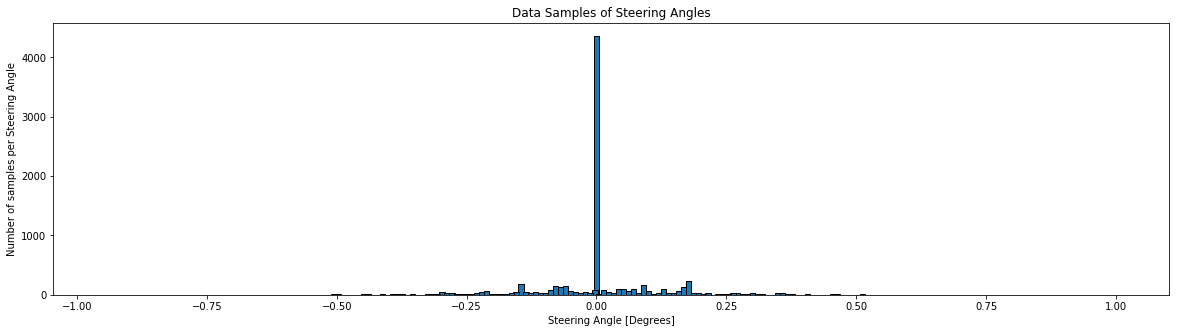

In [83]:
steering_data = drive_data['steering']



plt.figure(figsize=(20,5))
xticks = np.array(steering_data.value_counts().index.values.tolist())
plt.bar(xticks,
        steering_data.value_counts().tolist(),
        width=0.01,
        align='center',
        edgecolor='black');

plt.title('Data Samples of Steering Angles');
plt.ylabel('Number of samples per Steering Angle');
plt.xlabel('Steering Angle [Degrees]');



The graph above confirms the steering angles spread in a wide range(infinite) and seem to have a normal distribution. It confirms that it is not possible to assign a fixed number of classes to the steering angles labels. Thus, the **best approach** will be to use **supervised learning - regression** to predict the _steering angle_ rather than considering logistic regression, which usually goes together with CNN networks.

A simple histogram can help identify the groups better, so that we understand the distribution of steering angles.

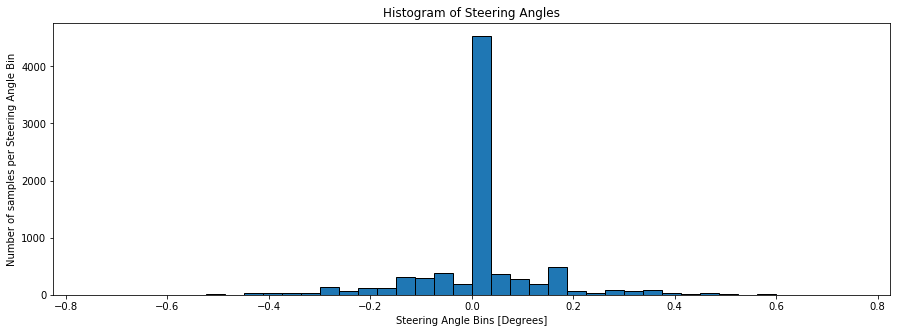

In [84]:
plt.figure(figsize=(15,5))
plt.hist(steering_data, bins=40 ,range=(-0.75,0.75),edgecolor='black');
plt.title('Histogram of Steering Angles');
plt.ylabel('Number of samples per Steering Angle Bin');
plt.xlabel('Steering Angle Bins [Degrees]');

### Some Statistics

Let's confirm that the **mode** for the **_steering angle_** is **_0.0_** with some simple statistics and at the same time get some statistics for the other numerical columns.

In [85]:
print(drive_data.describe())

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


After calculating the statistics of the data set, we confirmed that the _steering angle 0.0_ is the mode and that it is by a lot the value that repeats the most. This can cause our CNN to get bias and tend to predict an steering angle of 0.0 for most cases.

The previous analysis lead us to the conclusion that we need to either get more data where the steering angle is different than 0 or simply augment the data and that includes shifting the steering angle as part of it.

**NOTE:** _An important fact that we were missing to describe is that the histogram and data analysis above is done per row, meaning that every row is equivalent to three pictures. Thus, the actual values are three times what shown above if we intend to use left and right camera images._

In [86]:
print('Number of Steering Angles per Images Set [Center, Left, Right]: {}\n'.format(drive_data.shape[0]))
print('Total Number of Images: {}'.format(drive_data.shape[0]*3))

Number of Steering Angles per Images Set [Center, Left, Right]: 8036

Total Number of Images: 24108


### Visualizing Camera Images

The data is around 8036 per steering angle, but 3 images are associated to 1 steering angle. Thus, the total number of images is 24108. That is a very small data set, so augmentation is definitively an option for increasing the data set. 

In order to understand how to augment the data, it will be essential to look at what the images from the cameras look like.

Images Dimension:  160 x 320 x 3


Steering Angle: -0.2876218 degrees

Left Image  : ./data/IMG/left_2016_12_01_13_45_16_450.jpg
Center Image: ./data/IMG/center_2016_12_01_13_45_16_450.jpg
Right Image : ./data/IMG/right_2016_12_01_13_45_16_450.jpg

==================== ORIGINAL IMAGES ====================


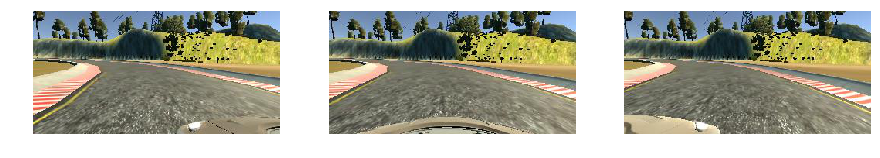

In [112]:
import random
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

def show_images(images, n_range=3):
    """
    Displays Images
    Arguments:
    @image: Dataset of images
    @n_range: number of images to display
    """
    grid1 = gridspec.GridSpec(1,3)
    grid1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
    plt.figure(figsize=(15,30))
    for i in range(n_range):
        ax1 = plt.subplot(grid1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        img = images[i]
        #img = transform_image(image,20,10,5,brightness=1)

        plt.subplot(1,3,i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()


DATA_ROW = random.randint(0, drive_data.shape[0])

center_img_path =  DATA_PATH + drive_data.iloc[DATA_ROW]['center'].strip() 
center_img = mpimg.imread(center_img_path)

left_img_path = DATA_PATH + drive_data.iloc[DATA_ROW]['left'].strip()
left_img = mpimg.imread(left_img_path)

right_img_path = DATA_PATH + drive_data.iloc[DATA_ROW]['right'].strip()
right_img = mpimg.imread(right_img_path)

print('Images Dimension:  {} x {} x {}\n\n'.format(center_img.shape[0],center_img.shape[1], center_img.shape[2]) )

print('Steering Angle: {} degrees\n'.format(drive_data.iloc[DATA_ROW]['steering']))
print('Left Image  : {}'.format(left_img_path))
print('Center Image: {}'.format(center_img_path))
print('Right Image : {}'.format(right_img_path))

print('\n==================== ORIGINAL IMAGES ====================')
imgs = [left_img, center_img, right_img]
show_images(imgs)

The images above show that picture is a bit translated depending on the camera that took the picture. This is what we expected and thus we can actually augment data by doing translations and shifting the steering angle.
Also, the only big difference in the pictures is the front of the car on the very bottom, without it we probably cannot tell if an image was taken from left, right or center. That previous observation can definitively help us when training the model by chopping the bottom part of the image.
Once the bottom is chopped, we probably do not care of the top part as it has threes and mountains which do not directly impact the lane that is our main focus here. Thus, it might be a good idea to remove the top part as well and give less cluttered pictures to the CNN so that it can learn better.